In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from src.data.data_loader import read_all, replace_back_clicks
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
df_article_names, df_html_stats, df_categories, df_links, df_shortest_path, df_unfinished, df_finished, df_sm, df_scat, df_article = read_all()

Unfinished Paths
---------------- 
Number of rows before filtering: 24875
Invalid target articles found: {'Charlottes web', 'Rat', 'Western Australia', 'Great', 'Netbook', 'Long peper', 'Kashmir', 'The Rock', 'Pikachu', 'Rss', 'Adolph Hitler', 'English', 'Test', ' Zebra', 'The', 'Usa', 'Christmas', 'Mustard', 'Macedonia', 'Fats', 'Bogota', 'Georgia', 'Podcast', 'Sportacus', 'Black ops 2'}
Invalid articles found in path: {'Private Peaceful', 'Pikachu', 'Local community', 'Osteomalacia', 'Wikipedia Text of the GNU Free Documentation License'}
Number of 'timeout' games with a duration of less than 30 minutes: 7
Number of rows after filtering: 24709 

Finished Paths
-------------- 
Number of rows before filtering: 51318
Invalid articles found in path: {'Osteomalacia', 'Local community', 'Pikachu', 'Wikipedia Text of the GNU Free Documentation License'}
Number of rows after filtering: 51196
df_article_names length: 4584
df_links length (unique linkTarget): 4128
df_links length (unique linkS

In [4]:
# Drop the dupicates
df_article = df_article.drop_duplicates('article')
len(df_article)

4584

In [5]:
df_article

,article,in_degree,out_degree,total_words,total_links,link_density,abstract_words,abstract_links,abstract_link_density,num_sections,num_subsections,num_tables,category
0,Áedán mac Gabráin,0,11,1841.0,12.0,0.006518,169.0,10.0,0.059172,5.0,0.0,0.0,History
1,Åland,0,19,2387.0,27.0,0.011311,400.0,9.0,0.022500,11.0,0.0,5.0,Countries
2,Édouard Manet,0,20,2901.0,28.0,0.009652,163.0,7.0,0.042945,3.0,11.0,2.0,People
3,Éire,0,8,2047.0,12.0,0.005862,339.0,6.0,0.017699,2.0,0.0,0.0,Countries
4,Óengus I of the Picts,0,10,2010.0,12.0,0.005970,254.0,6.0,0.023622,5.0,0.0,1.0,History
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,Zionism,25,74,9351.0,109.0,0.011657,454.0,16.0,0.035242,9.0,16.0,2.0,Religion
4590,Zirconium,15,42,1539.0,58.0,0.037687,522.0,28.0,0.053640,5.0,1.0,5.0,Science
4591,Zoroaster,9,28,2965.0,32.0,0.010793,216.0,3.0,0.013889,7.0,5.0,1.0,People
4592,Zuid-Gelders,5,5,276.0,6.0,0.021739,276.0,6.0,0.021739,0.0,0.0,1.0,Language and literature


In [6]:
paths_merged = pd.concat([df_finished, df_unfinished])
paths_merged = paths_merged['path'].apply(replace_back_clicks)

In [7]:
def build_article_graph(paths):
    """
    Build a directed graph from article paths.
    Each node is an article, and edges represent transitions between consecutive articles in a path.
    The edge weight is the number of times that transition appears.
    """
    G = nx.DiGraph()
    for path in paths:
        nodes = path.split(';')
        for i in range(len(nodes) - 1):
            u = nodes[i]
            v = nodes[i + 1]
            # Add edge or update weight
            if G.has_edge(u, v):
                G[u][v]['weight'] += 1
            else:
                G.add_edge(u, v, weight=1)
    return G

# Build the graph from paths_merged
G = build_article_graph(paths_merged)

# We'll set all columns except "article" as node attributes
attribute_df = df_article.set_index('article')
attributes = attribute_df.to_dict('index')

# Set node attributes
nx.set_node_attributes(G, attributes)

# Now G is a graph with:
# - Nodes: articles
# - Edges: transitions between articles with 'weight' attribute
# - Node attributes: in_degree, out_degree, total_words, etc. from df

# Example: Access node attributes for a given node:
print(G.nodes['14th century'])  # If '14th century' is a node name
# Example: Access edge attributes:
print(G['14th century']['15th century'])

{'in_degree': 71, 'out_degree': 31, 'total_words': 841.0, 'total_links': 39.0, 'link_density': 0.04637336504161712, 'abstract_words': 104.0, 'abstract_links': 5.0, 'abstract_link_density': 0.04807692307692308, 'num_sections': 4.0, 'num_subsections': 0.0, 'num_tables': 3.0, 'category': 'History'}
{'weight': 23}


In [8]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Identify articles in df_article that are not nodes in the graph
missing_articles = set(df_article['article']) - set(G.nodes)

# Display missing articles
print(f"Number of articles in df_article not present in the graph: {len(missing_articles)}")
print("Missing articles:")
print(missing_articles)


Number of nodes: 4175
Number of edges: 69460
Number of articles in df_article not present in the graph: 409
Missing articles:
{'Eurasian Oystercatcher', 'Stourbridge Lion', 'Military history of Puerto Rico', 'Louis Freeh', 'Geography of Africa', 'Turner syndrome', 'John Henninger Reagan', 'Actuary', 'Wigeon', 'Pro Milone', 'The Frogs', 'Sudanic languages', 'Graniteville train disaster', 'Project MKULTRA', 'Jordanhill railway station', 'Humbert Roque Versace', 'Wars of Castro', 'Cyclone Rosita', 'Southern Rockhopper Penguin', 'Crossbill', 'Mirabilis (plant)', 'European Greenfinch', 'Ohm', 'David Blanchflower', 'Polish–Muscovite War (1605–1618)', 'Common agouti', 'Eifel Aqueduct', 'Economy of Scotland', 'Ursuline Convent Riots', 'Keurusselkä', 'Chiltern Hills', 'Nicobar Long-tailed Macaque', 'The Catlins', 'Eustreptospondylus', 'Antarctosaurus', 'Umbrella Cockatoo', 'History of Limerick', 'Bahamas', 'Stanisław Lem', 'Marc Pugh', 'Albrecht Rodenbach', 'Nigella', 'HD 217107 b', 'Georg Fors

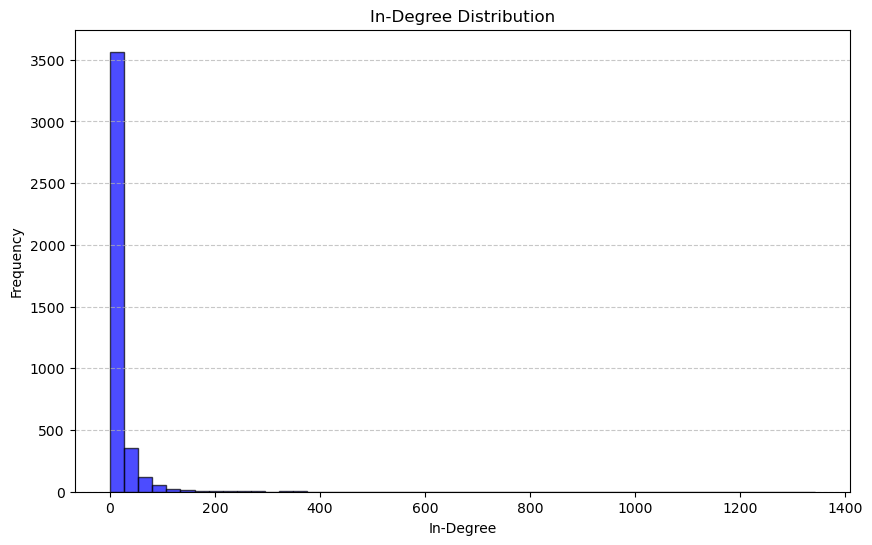

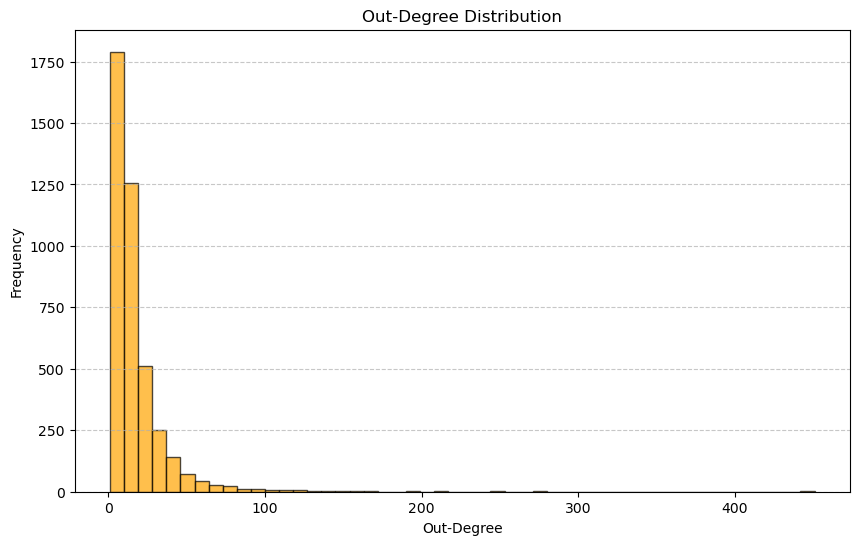

In [9]:
import matplotlib.pyplot as plt

# Compute in-degree and out-degree for all nodes
in_degrees = dict(G.in_degree())  # In-degree
out_degrees = dict(G.out_degree())  # Out-degree

# Convert to lists for plotting
in_degree_values = list(in_degrees.values())
out_degree_values = list(out_degrees.values())

# Plot In-Degree Distribution
plt.figure(figsize=(10, 6))
plt.hist(in_degree_values, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title("In-Degree Distribution")
plt.xlabel("In-Degree")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Out-Degree Distribution
plt.figure(figsize=(10, 6))
plt.hist(out_degree_values, bins=50, color='orange', alpha=0.7, edgecolor='black')
plt.title("Out-Degree Distribution")
plt.xlabel("Out-Degree")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [10]:
# 174 * (2) / ( 119* 118)
print("Network sparsity: %.4f" %nx.density(G))

Network sparsity: 0.0040


**Triadic Closure:**   
    A *friend* of my *friend* is my *friend*   
    OR   
    *quaker_1* knows *quaker_2* and *quaker_2* knows *quaker_3*, how likely is that *quaker_1* and *quaker_3* know each other?

Employ a **global** measure called **transitivity** (aka global clustering coefficient), or the ratio of all existing triangles (closed triples) over all possible triangles (open and closed triplets).

In [11]:
print('%.4f' %nx.transitivity(G))

0.1188


In [12]:
import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix

# Get a dense adjacency array (not memory-friendly for large graphs)
A_dense = nx.to_numpy_array(G, nodelist=sorted(G.nodes()), dtype=float)
A = csr_matrix(A_dense)

def approximate_largest_eigenvalue(A, max_iter=100, tol=1e-6):
    # A is assumed to be a scipy.sparse matrix
    n = A.shape[0]
    x = np.random.rand(n)
    x = x / np.linalg.norm(x)
    old_val = 0.0
    
    for i in range(max_iter):
        x_new = A.dot(x)
        val = np.linalg.norm(x_new)
        x_new = x_new / val
        if np.abs(val - old_val) < tol:
            break
        x = x_new
        old_val = val
    return val

lambda_max_approx = approximate_largest_eigenvalue(A)
alpha = 0.9 * (1/lambda_max_approx)  # pick alpha smaller than reciprocal of estimated eigenvalue
print(f"Approximate largest eigenvalue: {lambda_max_approx}, chosen alpha: {alpha}")


Approximate largest eigenvalue: 1455.5023428321033, chosen alpha: 0.0006183432163006953


#### What about the Katz Centrality (the generalization over degree centrality)?

In [13]:
from operator import itemgetter

# Compute Katz centrality
alpha = 0.01
katz_centralities = nx.katz_centrality(G, alpha=alpha, beta=1.0, max_iter=1000, tol=1e-06, normalized=True)

# Sort nodes by Katz centrality
sorted_katz = sorted(katz_centralities.items(), key=itemgetter(1), reverse=True)

n = 10  # Top n nodes

print("Top n Nodes by Katz Centrality:")
for node, centrality in sorted_katz[:n]:
    # Safely get category, in-degree, out-degree
    in_degree = G.in_degree(node)
    out_degree = G.out_degree(node)
    category = G.nodes[node].get('category', 'N/A')
    print(f"{node} | Category: {category} | Katz Centrality: {centrality:.6f} | In-Degree: {in_degree} | Out-Degree: {out_degree}")

Top n Nodes by Katz Centrality:
United States | Category: Countries | Katz Centrality: 0.223678 | In-Degree: 1342 | Out-Degree: 451
Europe | Category: Geography | Katz Centrality: 0.141254 | In-Degree: 751 | Out-Degree: 251
United Kingdom | Category: Countries | Katz Centrality: 0.140719 | In-Degree: 756 | Out-Degree: 273
World War II | Category: History | Katz Centrality: 0.108942 | In-Degree: 545 | Out-Degree: 195
England | Category: Geography | Katz Centrality: 0.107336 | In-Degree: 630 | Out-Degree: 275
France | Category: Countries | Katz Centrality: 0.106722 | In-Degree: 521 | Out-Degree: 159
Germany | Category: Countries | Katz Centrality: 0.088604 | In-Degree: 409 | Out-Degree: 170
English language | Category: Language and literature | Katz Centrality: 0.082198 | In-Degree: 378 | Out-Degree: 121
India | Category: Countries | Katz Centrality: 0.078114 | In-Degree: 354 | Out-Degree: 123
Africa | Category: Geography | Katz Centrality: 0.076297 | In-Degree: 372 | Out-Degree: 216


#### Betweeness centrality: the more shortest paths pass through a node, the more important it is!

In [14]:
# Compute betweenness centrality (exact)
betweenness = nx.betweenness_centrality(G, normalized=True)

# Sort nodes by betweenness
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

n = 10  # Top n nodes
print("Top n Nodes by Betweenness Centrality (Exact):")
for node, bc in sorted_betweenness[:n]:
    in_degree = G.in_degree(node)
    out_degree = G.out_degree(node)
    category = G.nodes[node].get('category', 'N/A')
    print(f"{node} | Category: {category} | Betweenness: {bc:.6f} | In-Degree: {in_degree} | Out-Degree: {out_degree}")

Top n Nodes by Betweenness Centrality (Exact):
United States | Category: Countries | Betweenness: 0.155940 | In-Degree: 1342 | Out-Degree: 451
United Kingdom | Category: Countries | Betweenness: 0.066740 | In-Degree: 756 | Out-Degree: 273
England | Category: Geography | Betweenness: 0.056107 | In-Degree: 630 | Out-Degree: 275
Europe | Category: Geography | Betweenness: 0.055323 | In-Degree: 751 | Out-Degree: 251
World War II | Category: History | Betweenness: 0.031895 | In-Degree: 545 | Out-Degree: 195
Africa | Category: Geography | Betweenness: 0.030577 | In-Degree: 372 | Out-Degree: 216
France | Category: Countries | Betweenness: 0.027708 | In-Degree: 521 | Out-Degree: 159
Germany | Category: Countries | Betweenness: 0.023617 | In-Degree: 409 | Out-Degree: 170
Earth | Category: Science | Betweenness: 0.020375 | In-Degree: 277 | Out-Degree: 147
London | Category: Geography | Betweenness: 0.019769 | In-Degree: 356 | Out-Degree: 146


### Homophily in articles (nodes)
How likely is it that two articles who have the same attribute are linked?

Try to measure the similarity of connections in the graph with respect to a given attribute.   
*Intuition: Like correlation, but translated to graphs.*

In [15]:
print(G.nodes['United States'])

{'in_degree': 1551, 'out_degree': 294, 'total_words': 9453.0, 'total_links': 457.0, 'link_density': 0.04834444091822702, 'abstract_words': 470.0, 'abstract_links': 42.0, 'abstract_link_density': 0.08936170212765958, 'num_sections': 10.0, 'num_subsections': 27.0, 'num_tables': 6.0, 'category': 'Countries'}


In [16]:
nx.attribute_assortativity_coefficient(G, 'category')

0.23393903773302827

In [17]:
nx.attribute_assortativity_coefficient(G, 'total_words')

-0.0006205002983634896

In [18]:
nx.attribute_assortativity_coefficient(G, 'link_density')

-0.0006950076864825694

In [19]:
nx.attribute_assortativity_coefficient(G, 'total_links')

-0.00011887756224751755

### Plot 

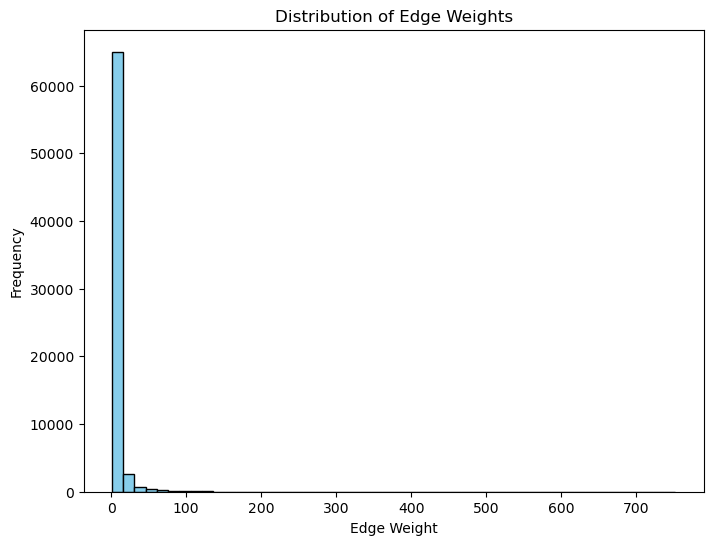

,Edge Weight Statistics
Count,69460.000000
Mean,5.730622
Median,2.000000
Standard Deviation,16.895467
Min,1.000000
Max,752.000000
25th Percentile,1.000000
75th Percentile,5.000000


In [20]:
from src.models.networks import filter_network, plot_network, analyze_edge_weights

analyze_edge_weights(G)

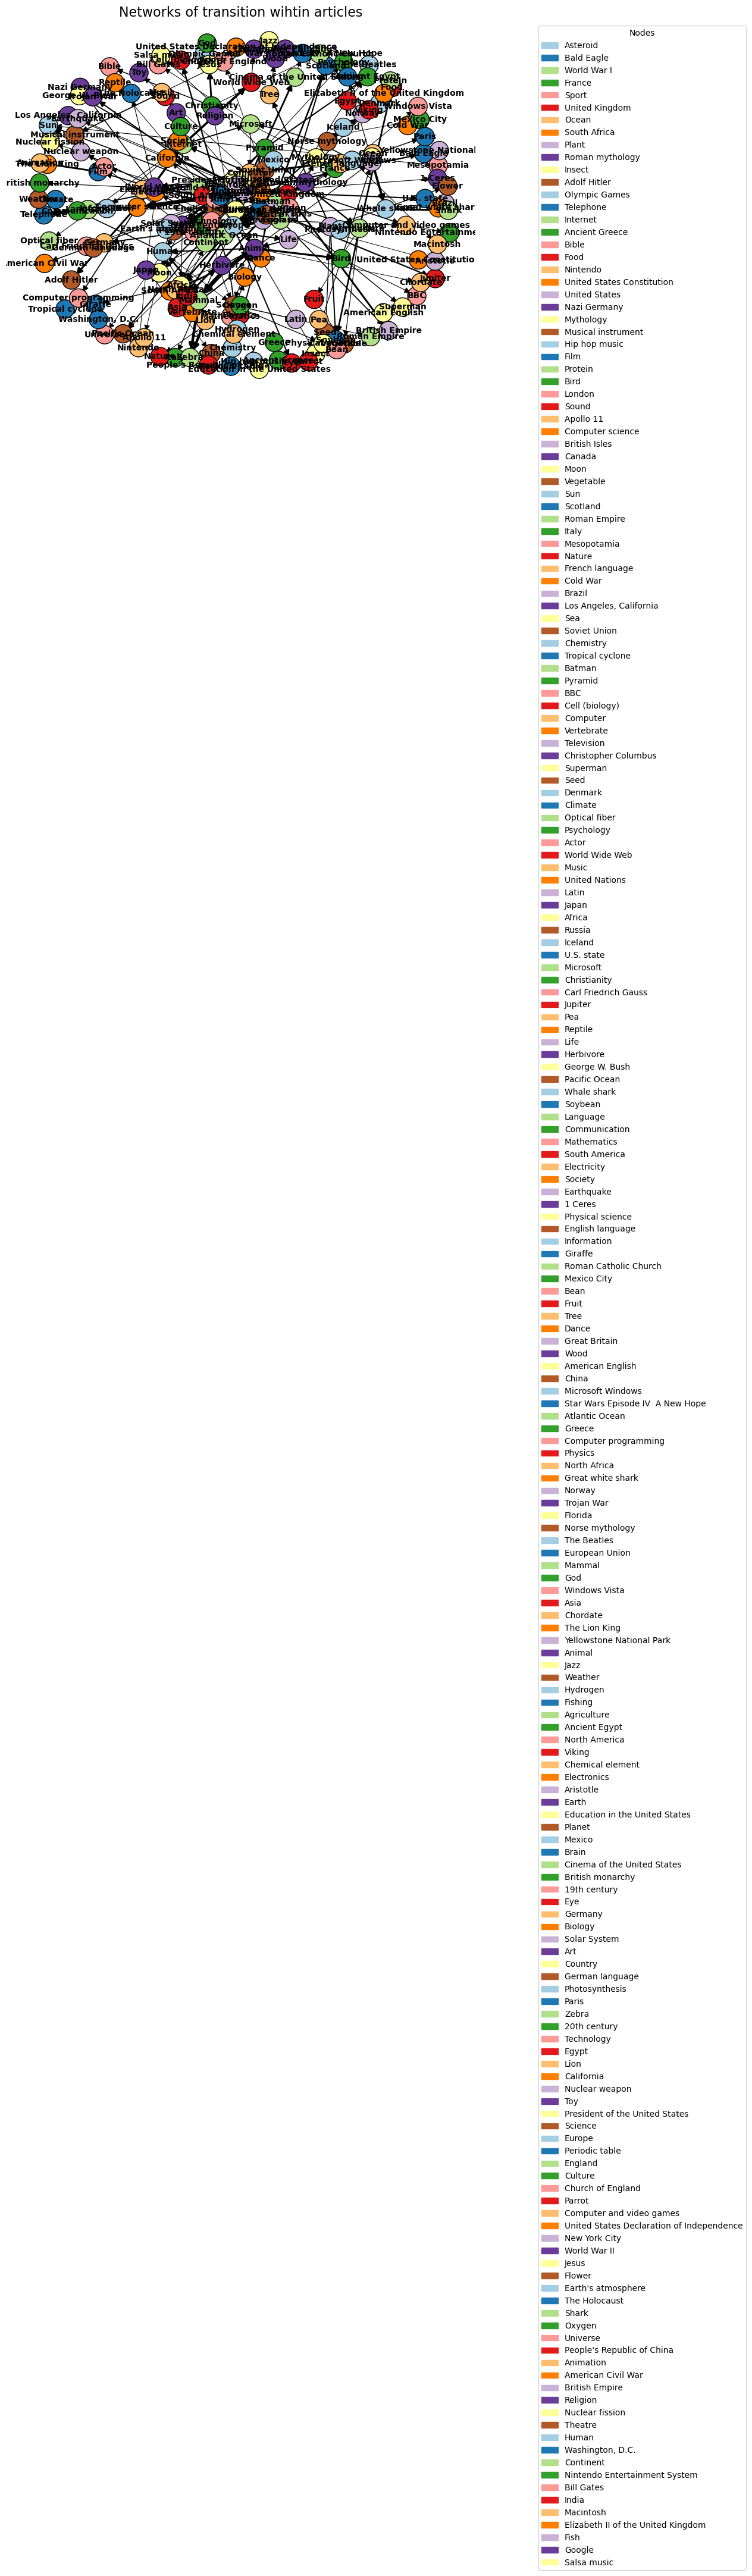

In [27]:
G_filter = filter_network(G,weight_threshold=100, top_n=20)
plot_network(G_filter, title="Networks of transition wihtin articles", show_edge_labels=False, node_size=500)